<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>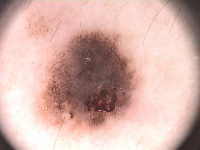</td><td>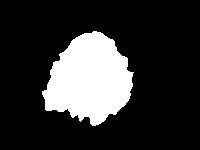</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [1]:
# !wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
# !wget -c https://disk.yandex.ru/d/vOGdIKrZ8qlAjQ

# import subprocess
# subprocess.run('unrar x PH2Dataset.rar')

In [2]:
!ls

 PH2Dataset  '[hw]semantic_segmentation.ipynb'	 history   models


Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [3]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [4]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [5]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [6]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

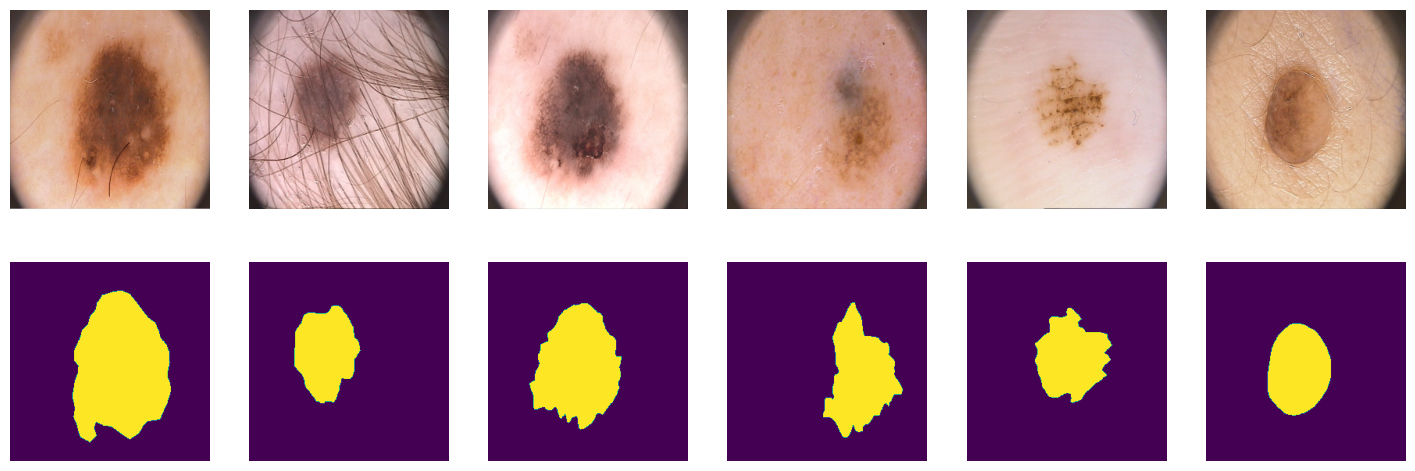

In [7]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [8]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [9]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [10]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_vl = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [11]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

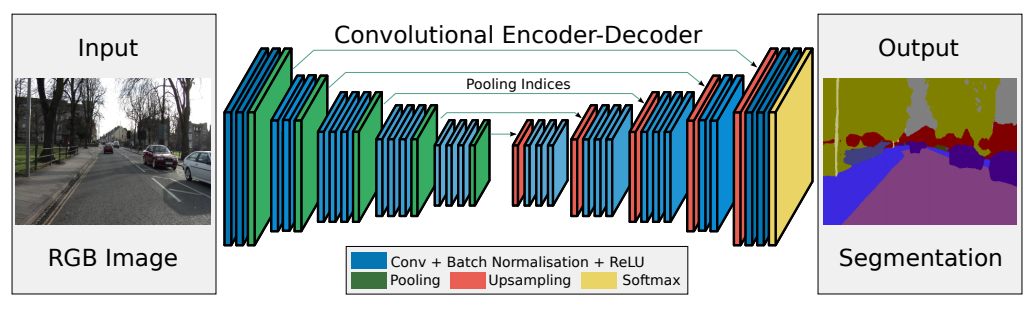

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [12]:
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [13]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight.data, nonlinearity="relu")
        elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.fill_(1.0)
            m.bias.data.fill_(1e-4)
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0.0, 0.0001)
            m.bias.data.zero_()

In [14]:
# activations_dict = nn.ModuleDict(
#     {
#         "relu": nn.ReLU(inplace=True),
#         "leaky_relu": nn.LeakyReLU(negative_slope=0.05, inplace=True),
#         "prelu": nn.PReLU(),
#         "gelu": nn.GELU(),
#         "sigmoid": nn.Sigmoid(),
#         "tanh": nn.Tanh(),
#         "none": nn.Identity(),
#     }
# )

class ConvBlock(nn.Module):
    def __init__(self, in_channels, n_filters, k_size, stride, padding, use_bn=True, use_act=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels,
                              n_filters,
                              kernel_size=k_size,
                              padding=padding,
                              stride=stride)
        self.bn = nn.BatchNorm2d(int(n_filters)) if use_bn else nn.Identity()
        self.act = nn.ReLU(inplace=True) if use_act else nn.Identity()
        # self.act = activations_dict[str(activation)]

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x


if __name__ == "__main__":
    print("Test ConvBlock.\n")
    x_dumb = torch.rand((1, 3, 256, 256)).cuda()
    print(f"X.shape: {x_dumb.shape}\n")

    conv_block = ConvBlock(3, 10, 3, 1, 1, use_bn=True, use_act=True).cuda()
    y_dumb = conv_block(x_dumb)
    for name, layer in conv_block.named_children():
        print(name, "\t\t", layer.__class__.__name__)
    print(f"Out.shape: {x_dumb.shape}\n")

    conv_block = ConvBlock(3, 10, 3, 1, 1, use_bn=False, use_act=False).cuda()
    y_dumb = conv_block(x_dumb)
    for name, layer in conv_block.named_children():
        print(name, "\t\t", layer.__class__.__name__)
    print(f"Out.shape: {x_dumb.shape}\n")


Test ConvBlock.

X.shape: torch.Size([1, 3, 256, 256])

conv 		 Conv2d
bn 		 BatchNorm2d
act 		 ReLU
Out.shape: torch.Size([1, 3, 256, 256])

conv 		 Conv2d
bn 		 Identity
act 		 Identity
Out.shape: torch.Size([1, 3, 256, 256])



In [15]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            ConvBlock(3, 64, 3, 1, 1),
            ConvBlock(64, 64, 3, 1, 1),
        )
        self.pool0 = nn.MaxPool2d(2, 2, return_indices=True)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            ConvBlock(64, 128, 3, 1, 1),
            ConvBlock(128, 128, 3, 1, 1),
        )
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True)  # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            ConvBlock(128, 256, 3, 1, 1),
            ConvBlock(256, 256, 3, 1, 1),
            ConvBlock(256, 256, 3, 1, 1),
        )
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True)  # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            ConvBlock(256, 512, 3, 1, 1),
            ConvBlock(512, 512, 3, 1, 1),
            ConvBlock(512, 512, 3, 1, 1),
        )
        self.pool3 = nn.MaxPool2d(2, 2, return_indices=True)  # 64 -> 32

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            ConvBlock(512, 1024, 1, 1, 0),
            ConvBlock(1024, 512, 1, 1, 0),
        )

        # decoder (upsampling)
        self.upsample3 = nn.MaxUnpool2d(2, 2)  # 16 -> 32
        self.dec_conv3 = nn.Sequential(
            ConvBlock(512, 256, 3, 1, 1),
            ConvBlock(256, 256, 3, 1, 1),
            ConvBlock(256, 256, 3, 1, 1),
        )
        self.upsample2 = nn.MaxUnpool2d(2, 2)  # 32 -> 64
        self.dec_conv2 = nn.Sequential(
            ConvBlock(256, 128, 3, 1, 1),
            ConvBlock(128, 128, 3, 1, 1),
            ConvBlock(128, 128, 3, 1, 1),
        )
        self.upsample1 = nn.MaxUnpool2d(2, 2)  # 64 -> 128
        self.dec_conv1 = nn.Sequential(
            ConvBlock(128, 64, 3, 1, 1),
            ConvBlock(64, 64, 3, 1, 1),
        )
        self.upsample0 = nn.MaxUnpool2d(2, 2)  # 128 -> 256
        self.dec_conv0 = nn.Sequential(
            ConvBlock(64, 1, 3, 1, 1),
            ConvBlock(1, 1, 3, 1, 1, use_bn=False, use_act=False),
        )

    def forward(self, x):
        # encoder
        e0, ind0 = self.pool0(self.enc_conv0(x))
        e1, ind1 = self.pool1(self.enc_conv1(e0))
        e2, ind2 = self.pool2(self.enc_conv2(e1))
        e3, ind3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        bottle_neck = self.bottleneck_conv(e3)

        # decoder
        d3 = self.dec_conv3(self.upsample3(bottle_neck, ind3))
        d2 = self.dec_conv2(self.upsample2(d3, ind2))
        d1 = self.dec_conv1(self.upsample1(d2, ind1))
        d0 = self.dec_conv0(self.upsample0(d1, ind0))

        return d0


In [16]:
if __name__ == "__main__":
    print("Test SegNet model")
    from torchsummary import summary
    model = SegNet().cuda()
    initialize_weights(model)
    summary(model, (3, 256, 256), device='cuda')
    # for name, layer in model.named_children():
    #     print(f"Layer name: {name}. \nLayer type: {layer.__class__.__name__}")

Test SegNet model
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         ConvBlock-4         [-1, 64, 256, 256]               0
            Conv2d-5         [-1, 64, 256, 256]          36,928
       BatchNorm2d-6         [-1, 64, 256, 256]             128
              ReLU-7         [-1, 64, 256, 256]               0
         ConvBlock-8         [-1, 64, 256, 256]               0
         MaxPool2d-9  [[-1, 64, 128, 128], [-1, 64, 128, 128]]               0
           Conv2d-10        [-1, 128, 128, 128]          73,856
      BatchNorm2d-11        [-1, 128, 128, 128]             256
             ReLU-12        [-1, 128, 128, 128]               0
        ConvBlock-13        [-1, 128, 128, 128]               0
      

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [17]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor, SMOOTH = 1e-8):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [18]:
def bce_loss(y_pred, y_real):
    loss = y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred))
    return loss.mean()


if __name__ == "__main__":
    print("Test bce_loss:\n")
    x0_dumb = torch.randn(3,256,256)
    x1_dumb = torch.randn(3,256,256)
    print(bce_loss(x0_dumb, x1_dumb))
    print(nn.BCEWithLogitsLoss()(x0_dumb, x1_dumb))


Test bce_loss:

tensor(0.8052)
tensor(0.8052)


## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [19]:
def save_model(model, dname="./", fname="model_full.pt"):
    """ Save entire net """
    fn_out = Path(dname) / fname
    torch.save(model, str(fn_out))


def save_params(model, dname="./", fname="model_params.pth"):
    """ Save only the parameters """
    fn_out = Path(dname) / fname
    torch.save(model.state_dict(), str(fn_out))


def restore_model(dname="./", fname="model_full.pkl"):
    """ Restore full model """
    full_path = Path(dname) / fname
    model = torch.load(str(full_path))
    return model


def restore_params(model, dname="./", fname="model_params.pkl"):
    """ Restore model's parameters """
    full_path = Path(dname) / fname
    state_dict = torch.load(str(full_path))
    model.load_state_dict(state_dict)
    return model

In [20]:
def train_process(model, loss_fn, score_fn, epochs, data_tr, data_vl):

    torch.cuda.empty_cache()

    model_name = model.__class__.__name__
    loss_name = loss_fn.__name__  # only for functions

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=0.00100,
        weight_decay=0.05,
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer=optimizer,
        mode='max',
        factor=0.5,
        patience=20,
    )

    history = {
        "train": defaultdict(list),
        "valid": defaultdict(list),
    }

    for epoch in range(epochs):
        # ----- TRAIN STAGE -----
        stage = 'train'
        losses_train = []
        model.train(True)  # train mode
        for x_batch, target in data_tr:
            x_batch = x_batch.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            output = model(x_batch)
            loss = loss_fn(output, target)
            loss_value = loss.detach().cpu().numpy()
            loss.backward()  # backward-pass
            optimizer.step()  # update weights
            losses_train.append(loss_value)
        avg_loss = sum(losses_train)/len(losses_train)  # avg loss on epoch
        avg_iou = score_fn(model, iou_pytorch, data_tr)  # train iou on epoch
        history[stage]['loss'].append(avg_loss)
        history[stage]['score'].append(avg_iou)

        if epoch % 20 == 0:
            print(
                f"Stage: {stage} | "
                f"epoch: {epoch:03d}/{epochs:03d} | "
                f"loss: {history[stage]['loss'][-1]:.5f} | "
                f"score: {history[stage]['score'][-1]:.5f}"
            )

        # ----- VALIDATION STAGE -----
        stage = "valid"
        losses_valid = []
        model.eval()  # testing mode
        for x_batch, target in data_vl:
            with torch.no_grad():
                x_batch = x_batch.to(device)
                target = target.to(device)
                output = model(x_batch)
                loss = loss_fn(output, target)
                loss_value = loss.detach().cpu().numpy()
                losses_valid.append(loss_value)

        avg_loss = sum(losses_valid)/len(losses_valid)  # avg loss on epoch
        avg_iou = score_fn(model, iou_pytorch, data_vl)  # val iou on epoch
        history[stage]['loss'].append(avg_loss)
        history[stage]['score'].append(avg_iou)

        # saving on the best score
        if history[stage]['score'][-1] == min(history[stage]['score']):
            save_model(model, fname=Path(f"models/{model_name}_{loss_name}_best.pt"))
            save_params(model, fname=Path(f"models/{model_name}_{loss_name}_weights_best.pth"))

        if epoch % 20 == 0:
            print(
                f"Stage: {stage} | "
                f"epoch: {epoch:03d}/{epochs:03d} | "
                f"loss: {history[stage]['loss'][-1]:.5f} | "
                f"score: {history[stage]['score'][-1]:.5f}"
            )

        if scheduler:
            scheduler.step(avg_iou)

        torch.cuda.empty_cache()

    # saving after train
    save_model(model, fname=Path(f'models/{model_name}_{loss_name}.pt'))
    save_params(model, fname=Path(f'models/{model_name}_{loss_name}_weights.pth'))
    with open(f'history/{model_name}_{loss_name}.hst', 'wb') as f:
        pickle.dump(history, f)

    return model, history


## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [21]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [22]:
def score_model(model, metric_fn, data, threshold=0.5):
    history = []
    model.train(False)  # eval mode
    for x, y in data:
        with torch.no_grad():
            x = x.to(device)
            y = y.to(device)
            output = model(x)
            # Выходы модели не приведены к 0 и 1, в отличие от масок
            # Буду приравнивать выходы больше порога к 1, а меньше или равные - к 0
            y_pred = F.sigmoid(output) > threshold
            # y_pred = torch.ones_like(Y_pred) * (Y_pred > 0.1)

            metric_value = metric_fn(y_pred, y).mean().detach().cpu().numpy()
            history.append(metric_value)

    return sum(history)/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [23]:
from pathlib import Path
import pickle

EPOCHS = 150
IS_TRAINING_MODE = True

In [24]:
def train_fn(model, loss_fn, is_training_mode=True):
    model = model.to(device)
    initialize_weights(model)
    model_name = model.__class__.__name__
    loss_fn_name = loss_fn.__name__
    
    if is_training_mode:
        model, history = train_process(
            model=model,
            loss_fn=loss_fn,
            score_fn=score_model,
            epochs=EPOCHS,
            data_tr=data_tr,
            data_vl=data_vl,
        )
    else:
        model = restore_model(fname=Path(f'models/{model_name}_{loss_fn_name}.pt'))
        # model = restore_params(model, fname=Path(f'models/{model_name}_{loss_fn_name}_weights.pth'))
        model = model.to(device)
        with open(f'history/{model_name}_{loss_fn_name}.hst', 'rb') as f:
            history = pickle.load(f)

    return model, history

In [25]:
model, history0_bce = train_fn(SegNet(), bce_loss, is_training_mode=False)

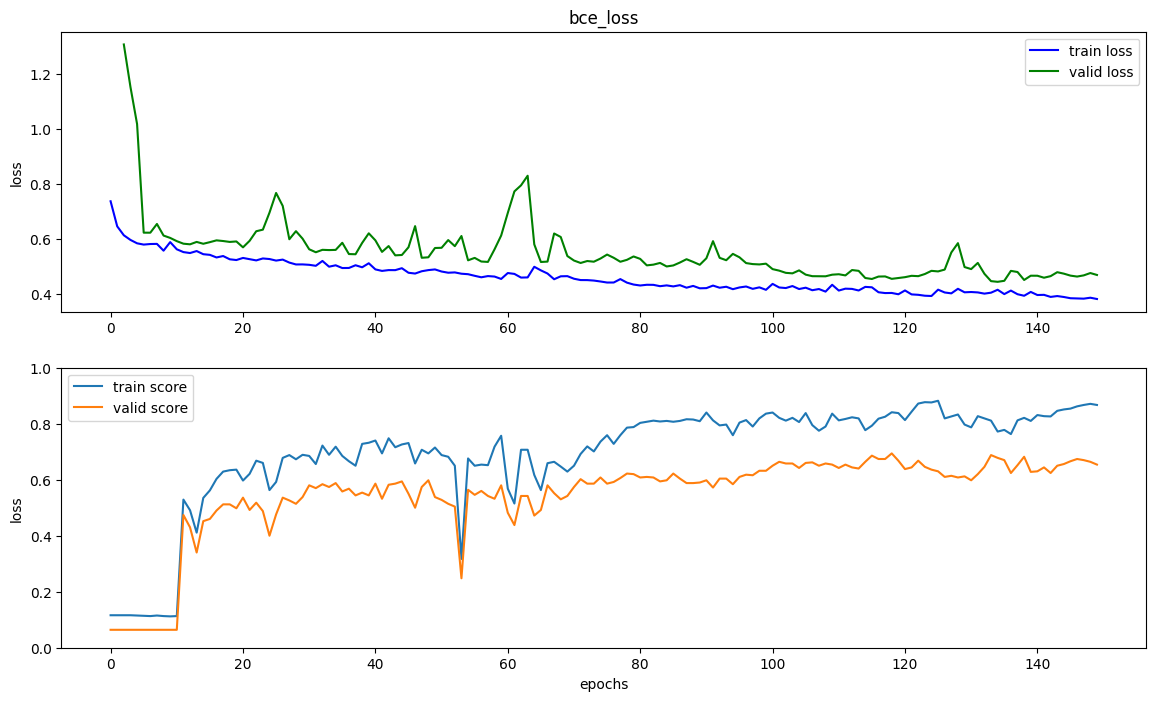

<Figure size 800x400 with 0 Axes>

In [26]:
def plot_results(history, title=''):
    fig, ax = plt.subplots(2, 1, figsize=(14, 8))
    # cmin=0., cmax=1., cmap='jet', interpolation='bilinear'

    plt.figure(figsize=(8, 4))
    ax[0].plot(history['train']['loss'], "b", label="train loss")
    ax[0].plot(history['valid']['loss'], "g", label="valid loss")
    ax[0].legend(loc='best')
    ax[0].set_ylabel("loss")
    ax[0].set_title(title)

    ax[1].plot(history['train']['score'], label="train score")
    ax[1].plot(history['valid']['score'], label="valid score")
    ax[1].legend(loc='best')
    ax[1].set_xlabel("epochs")
    ax[1].set_ylabel("loss")
    ax[1].set_ylim([0, 1])

    plt.show()


if __name__ == "__main__":
    plot_results(history0_bce, 'bce_loss')

In [27]:
# Проверим score обученной модели на валидационной и тестовой выборках
print(
    f"Score valid: {score_model(model, iou_pytorch, data_vl)}\n"
    f"Score test: {score_model(model, iou_pytorch, data_ts)}"
)

Score valid: 0.7240000069141388
Score test: 0.7880000174045563


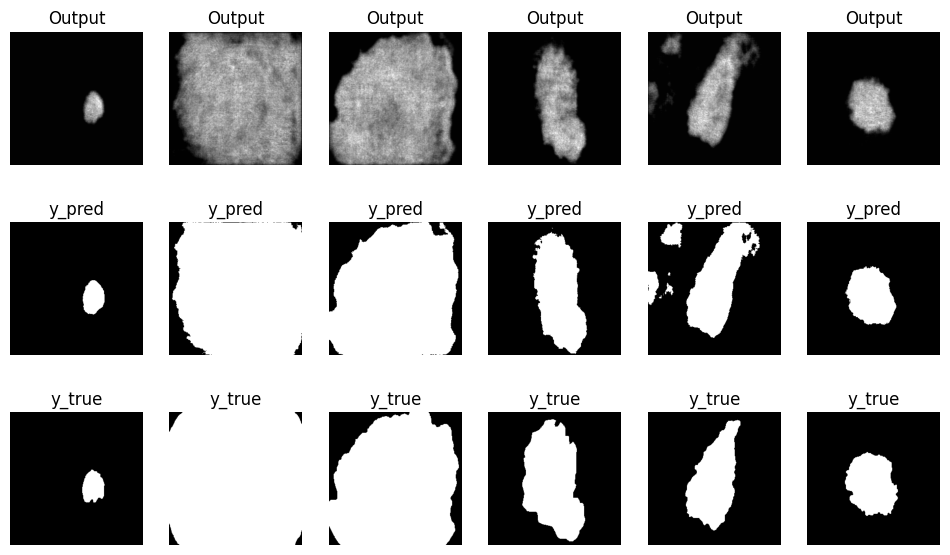

In [28]:
def plot_items(model, loader, cnt):

    model.eval()
    X, Y = next(iter(loader))
    X = X.to(device)
    Y_pred = model(X)

    p = Y_pred.detach().cpu()
    p_post = torch.ones_like(p) * (p > 0.1)
    y = Y
    
    plt.figure(figsize=(12, 7))
    for i in range(cnt):
        plt.subplot(3, cnt, i+1+cnt*0)
        plt.imshow(np.rollaxis(p[i,0].numpy(), 0), cmap='gray')
        plt.title('Output')
        plt.axis('off')
        
        plt.subplot(3, cnt, i+1+cnt*1)
        plt.imshow(np.rollaxis(p_post[i,0].numpy(), 0), cmap='gray')
        plt.title('y_pred')
        plt.axis('off')

        plt.subplot(3, cnt, i+1+cnt*2)
        plt.imshow(np.rollaxis(y[i,0].numpy(), 0), cmap='gray')
        plt.title('y_true')
        plt.axis('off')


if __name__ == "__main__":
    # На тестовой выборке сравним выходы модели c масками из обучающей выборки
    plot_items(model, data_ts, 6)
    

Ответьте себе на вопрос: не переобучается ли моя модель?

Т.к. на для train метрика IoU приближается к 1, а для valid результаты сильно отличаются, то это прямой признак перееобучуения на тренировочных данных. Текущая модель достаточно велика для такого небольшого датасета. Тюниться после другого датасета было бы предпочтительнее.

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [29]:
def dice_loss(y_pred, y_real, smooth = 1e-8):
    p = y_pred.sigmoid()
    t = y_real
    intersection = (p * t).sum()
    union = (p + t).sum()
    numerator = 2.0 * intersection + smooth
    denominator = union + smooth
    loss = 1 - numerator / denominator
    return loss

In [30]:
model, history0_dice = train_fn(SegNet(), dice_loss, is_training_mode=False)

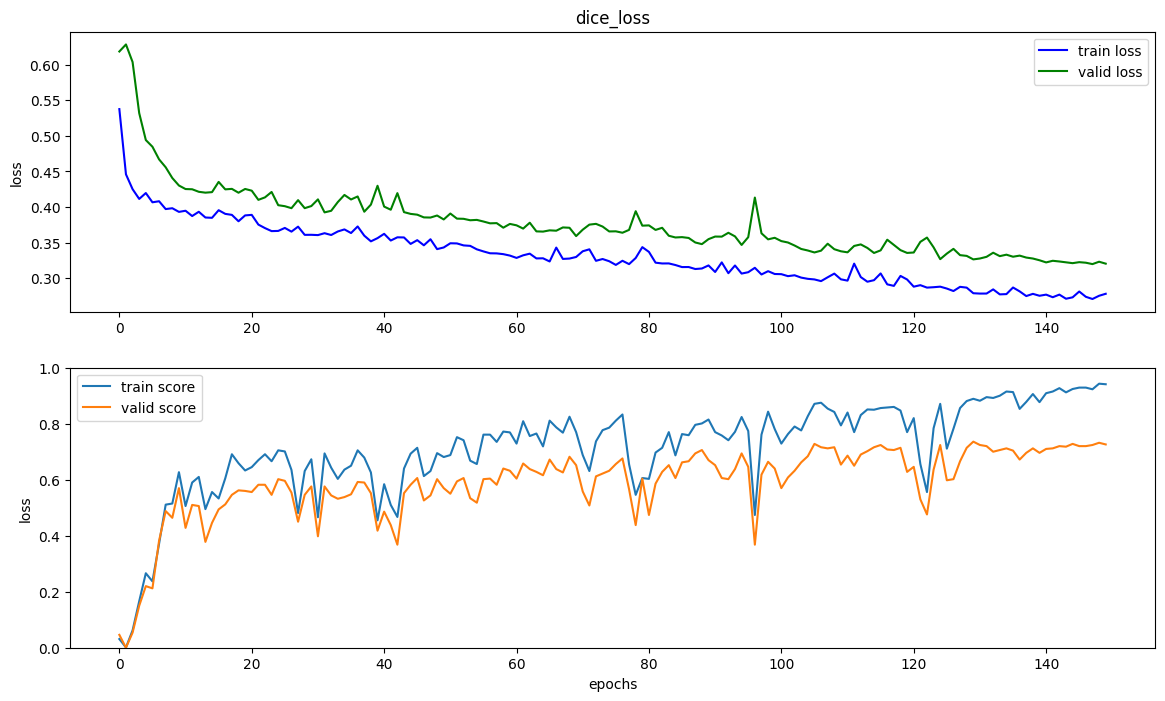

<Figure size 800x400 with 0 Axes>

In [31]:
plot_results(history0_dice, 'dice_loss')

In [32]:
# Проверим score обученной модели на валидационной и тестовой выборках
print(
    f"Score valid: {score_model(model, iou_pytorch, data_vl)}\n"
    f"Score test: {score_model(model, iou_pytorch, data_ts)}"
)

Score valid: 0.8199999928474426
Score test: 0.8939999938011169


[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [33]:
def focal_loss(y_pred, y_true, alpha=1, gamma=2, eps=1e-8):
    p = y_pred
    t = y_true
    # bce = F.binary_cross_entropy_with_logits(y_pred, y_real, reduction='none')
    bce = p - t * p + torch.log(1 + torch.exp(-p))
    pt = torch.exp(-bce)
    loss = alpha * (1 - pt)**gamma * bce
    return loss.mean()


def focal_loss_with_logtrick(y_pred, y_true, gamma=2, eps=1e-8):
    g = gamma
    exp = torch.exp
    ls = F.logsigmoid
    p = y_pred
    t = y_true
    loss = - ( t*ls(p)*exp(g*ls(-p)) + (1.0-t)*ls(-p)*exp(g*ls(p)) )
    return loss.mean()

In [34]:
model, history0_focal = train_fn(SegNet(), focal_loss_with_logtrick, is_training_mode=False)

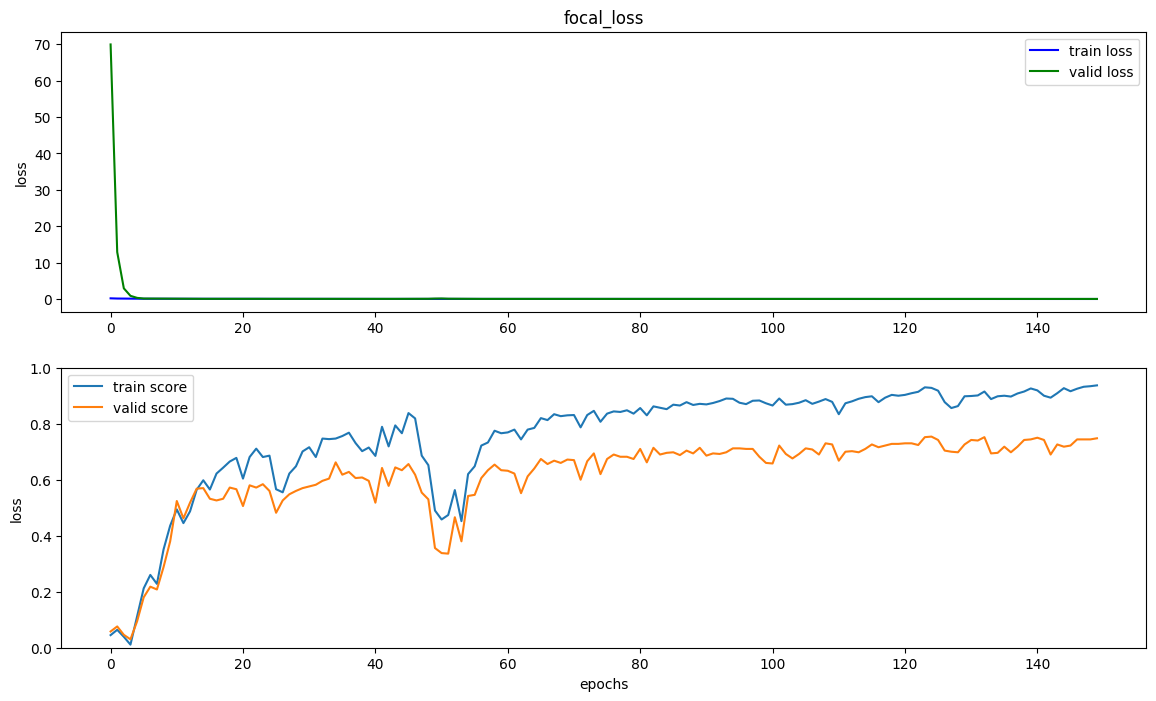

<Figure size 800x400 with 0 Axes>

In [35]:
plot_results(history0_focal, 'focal_loss')

In [36]:
# Проверим score обученной модели на валидационной и тестовой выборках
print(
    f"Score valid: {score_model(model, iou_pytorch, data_vl)}\n"
    f"Score test: {score_model(model, iou_pytorch, data_ts)}"
)

Score valid: 0.8020000457763672
Score test: 0.828000009059906


----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

In [37]:
def tversky_loss(y_pred, y_true, alpha=0.4, beta=0.6, smooth=1e-8):
    p = y_pred.sigmoid()
    t = y_true
    TP = (p * t).sum()
    FP = (p * (1.0 - t)).sum()
    FN = ((1.0 - p) * t).sum()
    # TN = not_need
    loss = 1.0 - (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)
    return loss


def tversky_loss(y_pred, y_true, alpha=0.4, beta=0.6, smooth=1e-8):
    a = alpha
    b = beta
    p = y_pred.sigmoid()
    t = y_true
    inters = (p * t).sum()  # intersection
    numer = inters  # numerator
    denom = inters + a*(p*(1.0-t)).sum() + b*((1.0-p)*t).sum()  # denominator
    loss = 1.0 - (numer + smooth) / (denom + smooth)
    return loss

In [38]:
model, history0_tversky = train_fn(SegNet(), tversky_loss, is_training_mode=False)

In [39]:
print(
    f"Score valid: {score_model(model, iou_pytorch, data_vl)}\n"
    f"Score test: {score_model(model, iou_pytorch, data_ts)}"
)

Score valid: 0.75
Score test: 0.784000039100647


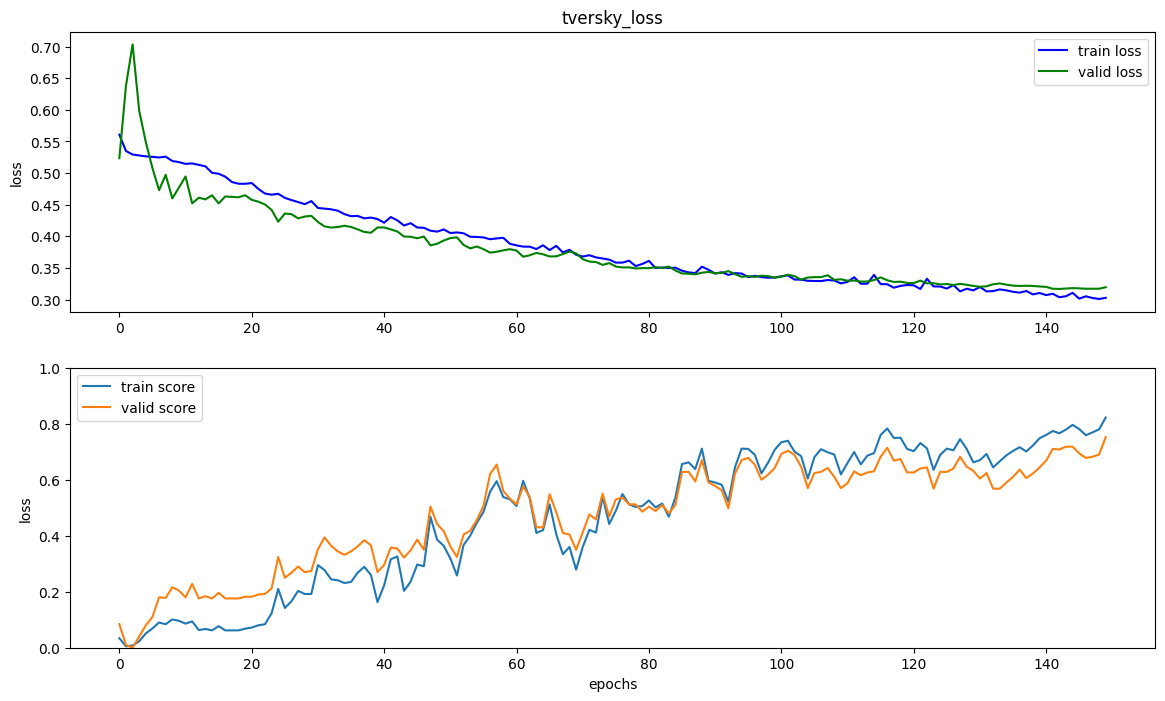

<Figure size 800x400 with 0 Axes>

In [40]:
plot_results(history0_tversky, 'tversky_loss')

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

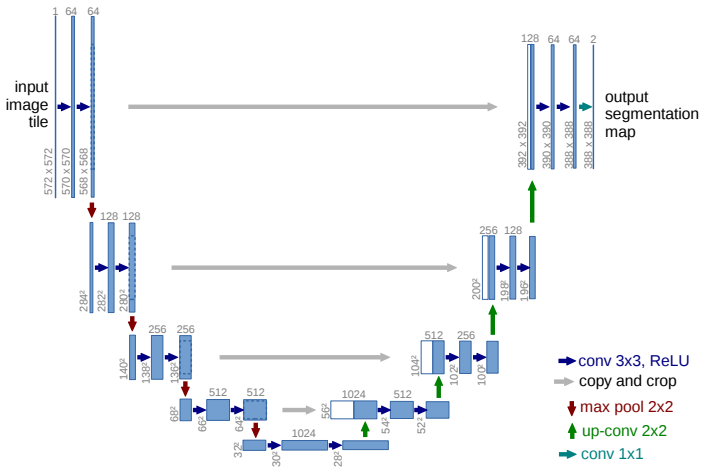

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [41]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            ConvBlock(3, 64, 3, 1, 1),
            ConvBlock(64, 64, 3, 1, 1)            
        )
        self.pool0 = nn.MaxPool2d(2, 2, return_indices=True)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            ConvBlock(64, 128, 3, 1, 1),
            ConvBlock(128, 128, 3, 1, 1),       
        )
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            ConvBlock(128, 256, 3, 1, 1),
            ConvBlock(256, 256, 3, 1, 1),
            ConvBlock(256, 256, 3, 1, 1)            
        )
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            ConvBlock(256, 512, 3, 1, 1),
            ConvBlock(512, 512, 3, 1, 1),
            ConvBlock(512, 512, 3, 1, 1)            
        )
        self.pool3 = nn.MaxPool2d(2, 2, return_indices=True) # 32 -> 16

        self.bottle_neck = nn.Sequential(
            ConvBlock(512, 1024, 1, 1, 0),
            ConvBlock(1024, 512, 1, 1, 0)   
        )

        self.upsample3 = nn.MaxUnpool2d(2, 2) # 16 -> 32
        self.dec_conv3 = nn.Sequential(
            ConvBlock(512*2, 256, 3, 1, 1),
            ConvBlock(256, 256, 3, 1, 1),
            ConvBlock(256, 256, 3, 1, 1),
        )

        self.upsample2 = nn.MaxUnpool2d(2, 2) # 32 -> 64
        self.dec_conv2 = nn.Sequential(
            ConvBlock(256*2, 128, 3, 1, 1),
            ConvBlock(128, 128, 3, 1, 1),
            ConvBlock(128, 128, 3, 1, 1),
        )

        self.upsample1 = nn.MaxUnpool2d(2, 2) # 64 -> 128
        self.dec_conv1 = nn.Sequential(
            ConvBlock(128*2, 64, 3, 1, 1),
            ConvBlock(64, 64, 3, 1, 1),
        )

        self.upsample0 = nn.MaxUnpool2d(2, 2) # 128 -> 256
        self.dec_conv0 = nn.Sequential(
            ConvBlock(64*2, 1, 3, 1, 1),
            ConvBlock(1, 1, 3, 1, 1, use_bn=False, use_act=False),
        )

    def forward(self, x):
        # encoder
        pre_e0 = self.enc_conv0(x)
        e0, ind0 = self.pool0(pre_e0)
        pre_e1 = self.enc_conv1(e0)
        e1, ind1 = self.pool1(pre_e1)
        pre_e2 = self.enc_conv2(e1)
        e2, ind2 = self.pool2(pre_e2)
        pre_e3 = self.enc_conv3(e2)
        e3, ind3 = self.pool3(pre_e3)        

        # bottleneck        
        bottle_neck = self.bottle_neck(e3)

        # decoder
        d3 = self.dec_conv3(torch.cat([self.upsample3(bottle_neck, ind3), pre_e3], 1))
        d2 = self.dec_conv2(torch.cat([self.upsample2(d3, ind2), pre_e2], 1))
        d1 = self.dec_conv1(torch.cat([self.upsample1(d2, ind1), pre_e1], 1))
        d0 = self.dec_conv0(torch.cat([self.upsample0(d1, ind0), pre_e0], 1))
        
        return d0

In [42]:
model, history1_bce = train_fn(UNet(), bce_loss, is_training_mode=False)
model, history1_dice = train_fn(UNet(), dice_loss, is_training_mode=False)
model, history1_focal = train_fn(UNet(), focal_loss_with_logtrick, is_training_mode=False)
model, history1_tversky = train_fn(UNet(), tversky_loss, is_training_mode=False)

In [43]:
print(
    f"Score valid: {score_model(model, iou_pytorch, data_vl)}\n"
    f"Score test: {score_model(model, iou_pytorch, data_ts)}"
)

Score valid: 0.8199999928474426
Score test: 0.8559999763965607


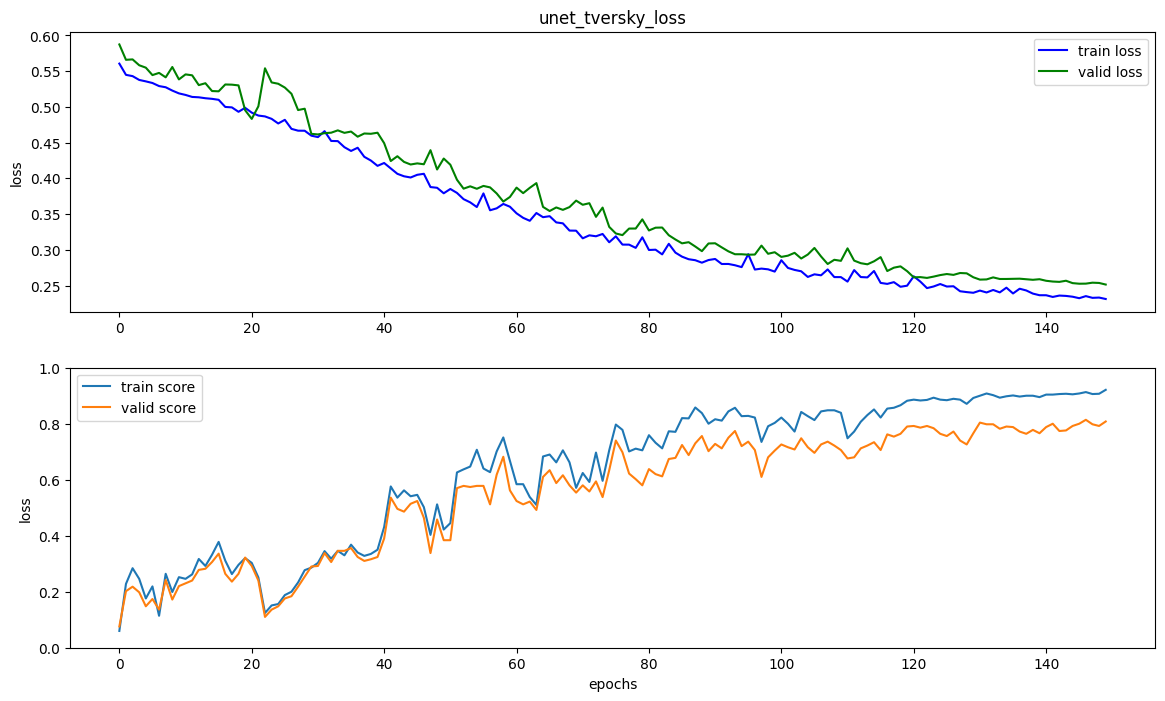

<Figure size 800x400 with 0 Axes>

In [44]:
plot_results(history1_tversky, 'unet_tversky_loss')

Из графиков валидационных оценок сложно сделать вывод, какой вариант даёт более качественный прогноз. Слишком большие выбросы. Возможно, слишком мало данных и сеть перееобучается. На Симпсонах всё было более гладко и предсказуемо. Посмотрим на сглаженные значения.

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [45]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            ConvBlock(3, 64, 3, 1, 1),
            ConvBlock(64, 64, 3, 1, 1)            
        )
        self.down0 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1) # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            ConvBlock(64, 128, 3, 1, 1),
            ConvBlock(128, 128, 3, 1, 1),       
        )
        self.down1 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            ConvBlock(128, 256, 3, 1, 1),
            ConvBlock(256, 256, 3, 1, 1),
            ConvBlock(256, 256, 3, 1, 1)            
        )
        self.down2 = nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            ConvBlock(256, 512, 3, 1, 1),
            ConvBlock(512, 512, 3, 1, 1),
            ConvBlock(512, 512, 3, 1, 1)            
        )
        self.down3 = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1) # 32 -> 16

        self.bottle_neck = nn.Sequential(
            ConvBlock(512, 1024, 1, 1, 0),
            ConvBlock(1024, 512, 1, 1, 0)   
        )

        self.up3 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1) # 16 -> 32
        self.dec_conv3 = nn.Sequential(
            ConvBlock(512*2, 256, 3, 1, 1),
            ConvBlock(256, 256, 3, 1, 1),
            ConvBlock(256, 256, 3, 1, 1),
        )

        self.up2 = nn.ConvTranspose2d(256, 256, kernel_size=3, stride=2, padding=1) # 32 -> 64
        self.dec_conv2 = nn.Sequential(
            ConvBlock(256*2, 128, 3, 1, 1),
            ConvBlock(128, 128, 3, 1, 1),
            ConvBlock(128, 128, 3, 1, 1),
        )

        self.up1 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1) # 64 -> 128
        self.dec_conv1 = nn.Sequential(
            ConvBlock(128*2, 64, 3, 1, 1),
            ConvBlock(64, 64, 3, 1, 1),
        )

        self.up0 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1) # 128 -> 256
        self.dec_conv0 = nn.Sequential(
            ConvBlock(64*2, 1, 3, 1, 1),
            ConvBlock(1, 1, 3, 1, 1, use_bn=False, use_act=False),
        )

    def forward(self, x):
        # encoder
        pre_e0 = self.enc_conv0(x)
        e0 = self.down0(pre_e0)
        pre_e1 = self.enc_conv1(e0)
        e1 = self.down1(pre_e1)
        pre_e2 = self.enc_conv2(e1)
        e2 = self.down2(pre_e2)
        pre_e3 = self.enc_conv3(e2)
        e3 = self.down3(pre_e3)

        # bottleneck        
        bottle_neck = self.bottle_neck(e3)

        # decoder       
        d3 = self.dec_conv3(torch.cat([self.up3(bottle_neck, output_size=pre_e3.size()), pre_e3], 1))
        d2 = self.dec_conv2(torch.cat([self.up2(d3, output_size=pre_e2.size()), pre_e2], 1))
        d1 = self.dec_conv1(torch.cat([self.up1(d2, output_size=pre_e1.size()), pre_e1], 1))
        d0 = self.dec_conv0(torch.cat([self.up0(d1, output_size=pre_e0.size()), pre_e0], 1))

        return d0

In [46]:
model, history2_bce = train_fn(UNet2(), bce_loss, is_training_mode=False)
model, history2_dice = train_fn(UNet2(), dice_loss, is_training_mode=False)
model, history2_focal = train_fn(UNet2(), focal_loss, is_training_mode=False)
model, history2_tversky = train_fn(UNet2(), tversky_loss, is_training_mode=False)

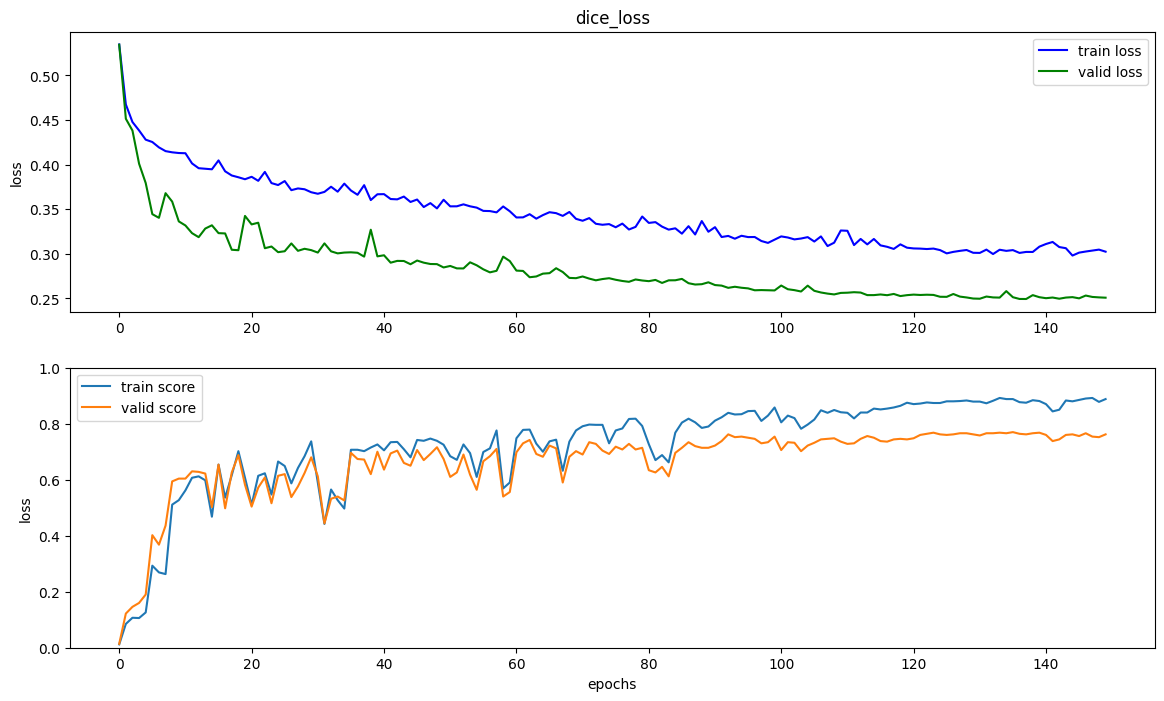

<Figure size 800x400 with 0 Axes>

In [47]:
plot_results(history2_dice, 'dice_loss')

Сделайте вывод, какая из моделей лучше

### Вывод.

Концептуально UNet2 должен быть предпочтительнее. Экспериментально же UNet1 немного лучше выглядит по метриками, нежели остальные.

Отчасти, причиной этому может быть тот факт, что для Unet1 нужно меньше параметров для обучения при прочих равных. На начальных этапах loss распределяет больше потерь среди оставшихся параметров и таким образом сходится быстрее. В данной работе не преследовались цели учить до лучшего результата, поэтому нет возможности сравнивать конечные результаты, а только лишь промежуточные.

К тому же играет роль, что датасет небольшого объема - нейронки просто "впитывают его", не позволяя выделиться архитектурным особенностям в полной мере.

Segnetу же плохо тем, что нужно полностью прогнать через себя входной сигнал, но тривиальные задачи можно решать через верхнеуровневые связи у Uneta.

Дальнешие эксперименты, но с другими вводными данными могут пролить свет на многие особенности и тонкости процесса.

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

<Figure size 1000x600 with 0 Axes>

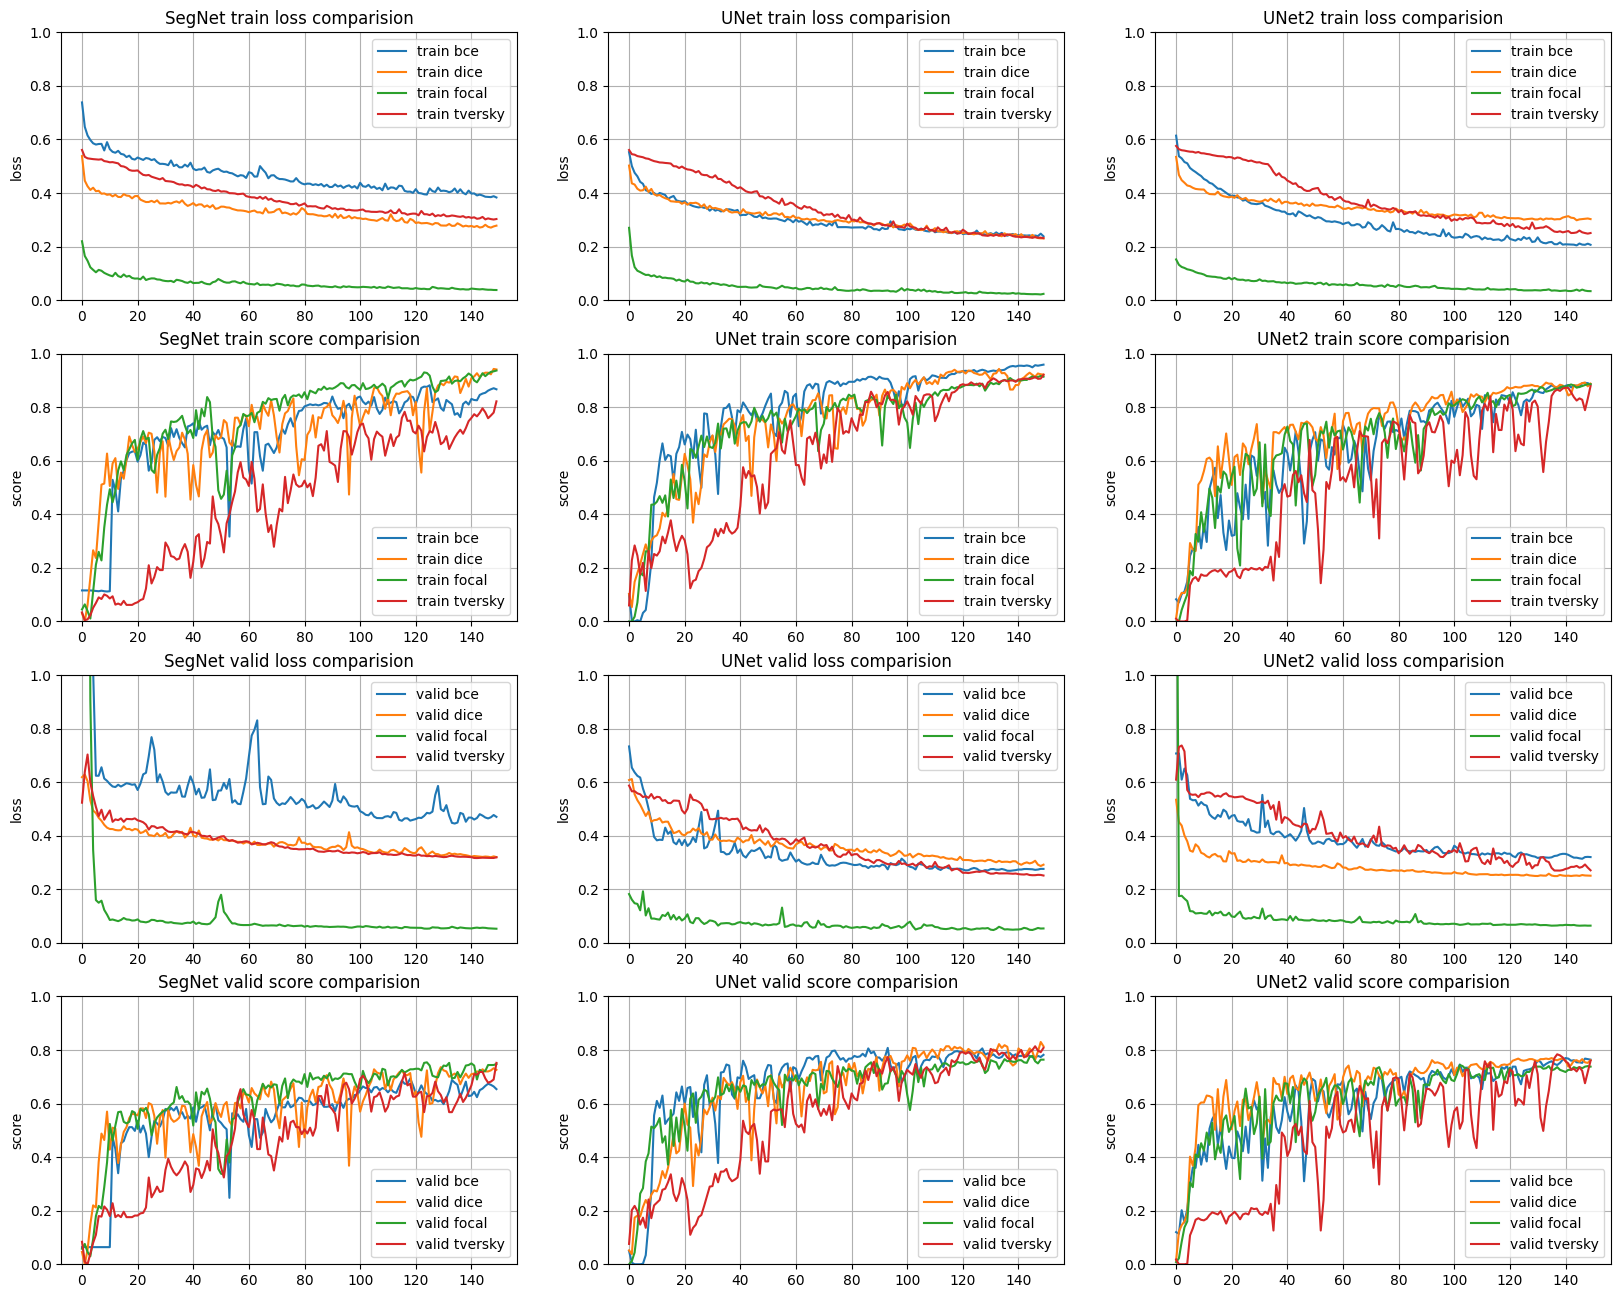

In [51]:
from itertools import product

plt.figure(figsize=(10, 6))
fig, ax = plt.subplots(4, 3, figsize=(20, 16))


for i, (stage, metric) in enumerate(product(['train', 'valid'], ['loss', 'score'])):
    model_name = "SegNet"
    ax[i][0].plot(history0_bce[stage][metric], label=f"{stage} bce")
    ax[i][0].plot(history0_dice[stage][metric], label=f"{stage} dice")
    ax[i][0].plot(history0_focal[stage][metric], label=f"{stage} focal")
    ax[i][0].plot(history0_tversky[stage][metric], label=f"{stage} tversky")
    ax[i][0].legend(loc='best')
    ax[i][0].set_ylim([0, 1])
    ax[i][0].set_ylabel(metric)
    ax[i][0].set_title(f"{model_name} {stage} {metric} comparision")
    ax[i][0].grid('on')
    model_name = "UNet"
    ax[i][1].plot(history1_bce[stage][metric], label=f"{stage} bce")
    ax[i][1].plot(history1_dice[stage][metric], label=f"{stage} dice")
    ax[i][1].plot(history1_focal[stage][metric], label=f"{stage} focal")
    ax[i][1].plot(history1_tversky[stage][metric], label=f"{stage} tversky")
    ax[i][1].legend(loc='best')
    ax[i][1].set_ylim([0, 1])
    ax[i][1].set_ylabel(metric)
    ax[i][1].set_title(f"{model_name} {stage} {metric} comparision")
    ax[i][1].grid('on')
    model_name = "UNet2"
    ax[i][2].plot(history2_bce[stage][metric], label=f"{stage} bce")
    ax[i][2].plot(history2_dice[stage][metric], label=f"{stage} dice")
    ax[i][2].plot(history2_focal[stage][metric], label=f"{stage} focal")
    ax[i][2].plot(history2_tversky[stage][metric], label=f"{stage} tversky")
    ax[i][2].legend(loc='best')
    ax[i][2].set_ylim([0, 1])
    ax[i][2].set_ylabel(metric)
    ax[i][2].set_title(f"{model_name} {stage} {metric} comparision")
    ax[i][2].grid('on')
plt.show()

Сравнительные графики выше.

Из креативного:
- He-инициализацию для весов.
- Logtrick для focal loss.
- Использование Scheduler.
- Сохранение best моделей.
- Активации через ModuleDict.
- ~~Хуки для принта размерностей.~~ torchmetrics.

Что нужно улучшить:
- Переписать модели через ModuleList/ModuleDict.
- Переписать Loss функции для задач multilabel/multiclass.
- Добавить полезных метрик.
- Автоматизировать процесс, например, через lightning.
- Другое бесконечное количество улучшалок)

Не судите строго, что опоздал на несколько часов от мягкого дедлайна. Спасибо!